In [16]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from spectral_decomposition import spectrum
import pandas as pd
import seaborn as sns
from scipy.fft import fft, fftfreq
from scipy.signal import windows

In [17]:
def generate_data(random_state = 42): 
    data = spectrum(
        sampling_rate=1000,
        duration=30,
        aperiodic_exponent=2.0,
        aperiodic_offset=2.0,
        knee=200,
        peaks=[{'freq':12, 'amplitude': 1.0, 'sigma': 2.0}],
        average_firing_rate=0.0,
        random_state=random_state,
        direct_estimate=True,
    )
    return data

data = generate_data()
data_td = data.time_domain.combined_signal
data_fd = data.frequency_domain

In [18]:
from scipy.signal import periodogram

def single_taper_package(signal, window_length_sec, taper_shape, fs=1000):
    N = int(fs * window_length_sec)
    x = signal[-N:] # obtain last chunk
    freqs, psd = periodogram(x, fs=fs, window=taper_shape, scaling='density', return_onesided=True)
    # drop nyquist bin
    if freqs[-1] == fs / 2:
        freqs = freqs[:-1]
        psd = psd[:-1]
    return freqs, psd

def single_taper_manual(signal, window_length, taper_shape, fs=1000):
    """
    Args: 
    - signal: signal, time domain 
    - window_length: in seconds
    - taper_shape: string, desired taper
    - fs: sampling frequency, default = 1000

    Returns:
    - freqs: positive frequencies
    - psd: estimated power spectral density for positive frequencies (doubled)
    """
    
    N = int(window_length * fs)  # number of samples in window
    x = signal[-N:] # retrive last chunk
    window = windows.get_window(taper_shape, N)
    U = (1/N) * np.sum(window ** 2)

    tapered = x * window
    fft_result = np.fft.rfft(tapered, n = N) # rfft only returns nonnegative frequencies
    psd = (np.abs(fft_result)**2) / (fs * N * U)

    # double the power except for 0
    psd[1:] *= 2

    freqs = np.fft.rfftfreq(N, d=1/fs)

    # drop nyquist if present; only true if N is even
    if freqs[-1] == fs / 2:
        freqs = freqs[:-1]
        psd = psd[:-1]

    return freqs, psd

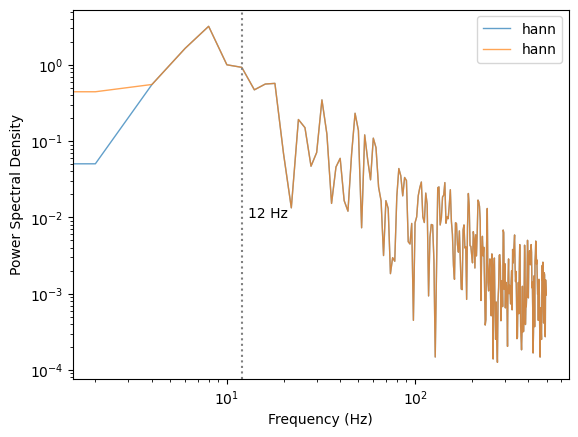

In [ ]:
import matplotlib.pyplot as plt

window_length = 0.5 # change window length

freq_hann_package, psd_hann_package = single_taper_package(data_td, window_length_sec=window_length, taper_shape='hann')
freq_hann_manual, psd_hann_manual = single_taper_manual(data_td, window_length=window_length, taper_shape='hann')


plt.loglog(freq_hann_package, psd_hann_package, linewidth=1, alpha=0.7, label='hann (package)')
plt.loglog(freq_hann_manual, psd_hann_manual, linewidth=1, alpha=0.7, label='hann (manual)')


plt.axvline(x=12, color='gray', linestyle=':', linewidth=1.5)
plt.text(13, 0.01,'12 Hz')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.legend()
plt.show()